In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *
%matplotlib inline


import os,sys
from PIL import Image
import cv2 #OpenCV library
from tqdm import tqdm

In [2]:
DATA_HOME_DIR = os.getcwd()

In [3]:
%pwd

'/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/Age-Detection-of-Indian-Actors-master 2'

'/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/Age-Detection-of-Indian-Actors-master 2'

In [4]:
%ls

Age_detection_indian_actors.ipynb
Keras_CNN_Age_Detection.ipynb
Keras_CNN_Age_Detection_Improved.ipynb
README.md
ResNet+LRScheduleOnSGD(ExpDecay)+HalfPrecision.ipynb
Sample_Submission.csv
Test/
Train/
TrainingWithFastai.ipynb
age-detection_weights.h5
dataset/
initial_weights.h5
leakyReLU_age-detection_weights.h5
sub/
sub.csv
sub03_2_leakyReLU.csv
test.csv
train.csv
Age_detection_indian_actors.ipynb
Keras_CNN_Age_Detection.ipynb
Keras_CNN_Age_Detection_Improved.ipynb
README.md
ResNet+LRScheduleOnSGD(ExpDecay)+HalfPrecision.ipynb
Sample_Submission.csv
Test/
Train/
TrainingWithFastai.ipynb
age-detection_weights.h5
dataset/
initial_weights.h5
leakyReLU_age-detection_weights.h5
sub/
sub.csv
sub03_2_leakyReLU.csv
test.csv
train.csv


In [5]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
TRAIN_PATH = DATA_HOME_DIR + '/Train/'
TEST_PATH = DATA_HOME_DIR + '/Test/'

In [7]:
# function to read images as arrays
def read_image(img_path, mode = 'color', resize = False, size = 32):
    '''
    Default mode is : color(BGR) --> color(RGB)
    Other modes allowed are : 'grayscale' and 'include_opacity'
    '''
    if mode == 'grayscale':
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif mode == 'include_opacity':
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if resize == True:
        img = cv2.resize(img, (size, size))
    
    return img

In [8]:
## Storing all images as list of arrays
train_data = []
test_data = []

for img in tqdm(train['ID'].values):
    train_data.append(read_image(TRAIN_PATH + '{}'.format(img), resize = True, size = 32))
    
for img in tqdm(test['ID'].values):
    test_data.append(read_image(TEST_PATH + '{}'.format(img), resize = True, size = 32))

100%|██████████| 6636/6636 [00:07<00:00, 930.98it/s] 



In [9]:
y_train = train['Class'].values


In [10]:
## Checking dimensions and aspect ratio of original images (without resizing)
rows = [x.shape[0] for x in (train_data+test_data)]
cols = [x.shape[1] for x in (train_data+test_data)]
channels = [x.shape[2] for x in (train_data+test_data)]
aspect_ratio = [x.shape[0]/x.shape[1] for x in (train_data+test_data)]

In [11]:
## Checking range of the dimesnions and aspect ratio
print("Min. and Max. rows = {} and {} respectively \nMin. and Max. cols = {} and {} respectively \nMin. and Max. channels = {} and {} respectively \nMin. and Max. aspect ratio = {} and {} respectively \n"
      .format(min(rows), max(rows), min(cols), max(cols), min(channels), max(channels), min(aspect_ratio), max(aspect_ratio)))


Min. and Max. rows = 32 and 32 respectively 
Min. and Max. cols = 32 and 32 respectively 
Min. and Max. channels = 3 and 3 respectively 
Min. and Max. aspect ratio = 1.0 and 1.0 respectively 

Min. and Max. rows = 32 and 32 respectively 
Min. and Max. cols = 32 and 32 respectively 
Min. and Max. channels = 3 and 3 respectively 
Min. and Max. aspect ratio = 1.0 and 1.0 respectively 



In [12]:
train.groupby(by = "Class").count()


,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


In [13]:
%ls

Age_detection_indian_actors.ipynb
Keras_CNN_Age_Detection.ipynb
Keras_CNN_Age_Detection_Improved.ipynb
README.md
ResNet+LRScheduleOnSGD(ExpDecay)+HalfPrecision.ipynb
Sample_Submission.csv
Test/
Train/
TrainingWithFastai.ipynb
age-detection_weights.h5
dataset/
initial_weights.h5
leakyReLU_age-detection_weights.h5
sub/
sub.csv
sub03_2_leakyReLU.csv
test.csv
train.csv
Age_detection_indian_actors.ipynb
Keras_CNN_Age_Detection.ipynb
Keras_CNN_Age_Detection_Improved.ipynb
README.md
ResNet+LRScheduleOnSGD(ExpDecay)+HalfPrecision.ipynb
Sample_Submission.csv
Test/
Train/
TrainingWithFastai.ipynb
age-detection_weights.h5
dataset/
initial_weights.h5
leakyReLU_age-detection_weights.h5
sub/
sub.csv
sub03_2_leakyReLU.csv
test.csv
train.csv


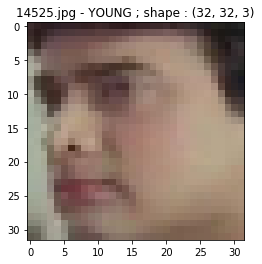

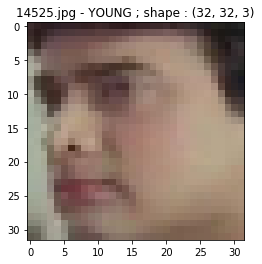

In [14]:
## Displaying random images without resizing
i = np.random.choice(np.arange(len(train_data)))

plt.title('{} - {} ; shape : {}'.format(train['ID'].values[i], y_train[i], train_data[i].shape))
plt.imshow(train_data[i])

In [15]:
## Scaling the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [16]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

In [17]:
y_train.shape


(19906, 3)

(19906, 3)

In [18]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
#K.set_image_dim_ordering('tf')

from keras.preprocessing import image

In [19]:

#os.environ['KERAS_BACKEND'] = 'theano'
#reload(K)

In [20]:
        
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [23]:
model = Sequential([
        BatchNormalization(input_shape = (128,128,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [25]:

model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='linear'),
        LeakyReLU(alpha = 0.3),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:

## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)       

In [28]:
## Building a custom function for learning rate decay/annealing
def lr_decay(start, stop, div_step_1, div_step_2 = 2) :
    k = 1
    while start >= stop:
        yield start
        if k==1 :
            start/= div_step_1
        else : start/= div_step_2
        k = k * -1

In [29]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)


Epoch 1/2
Epoch 1/2
498/498 [==============================] - 60s 121ms/step - loss: 1.2543 - accuracy: 0.5881 - val_loss: 0.7692 - val_accuracy: 0.6630
Epoch 2/2
498/498 [==============================] - 60s 120ms/step - loss: 0.7756 - accuracy: 0.6652 - val_loss: 0.7032 - val_accuracy: 0.6931


In [30]:
model.optimizer.lr = model.optimizer.lr /10


In [31]:
## Saving weights as a form of model checkpointing
model.save_weights('age-detection_weights.h5')

In [32]:
from sklearn.model_selection import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [33]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 64)
val_batches = gen.flow(X_valid, y_valid, batch_size = 128)

In [34]:
model.optimizer.lr = 0.001


In [35]:

model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
248/248 [==============================] - 53s 214ms/step - loss: 0.7616 - accuracy: 0.6691 - val_loss: 0.7027 - val_accuracy: 0.6946


In [36]:
model.optimizer.lr = (1/10)

In [37]:
model.fit_generator(batches, steps_per_epoch = (X_trn.shape[0]//batches.batch_size), epochs=2,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]/val_batches.batch_size))


Epoch 1/2
Epoch 1/2
248/248 [==============================] - 52s 211ms/step - loss: 1064.3918 - accuracy: 0.4207 - val_loss: 360.8619 - val_accuracy: 0.1296
Epoch 2/2
Epoch 2/2
248/248 [==============================] - 53s 213ms/step - loss: 23.2301 - accuracy: 0.4249 - val_loss: 4.4942 - val_accuracy: 0.5347


In [38]:
for i in lr_decay(0.005, 0.0002, 2, 5):
    model.optimizer.lr = i
    print("Learning rate = " + str(i))
    model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Learning rate = 0.005
Learning rate = 0.005
248/248 [==============================] - 56s 226ms/step - loss: 4.0031 - accuracy: 0.4401 - val_loss: 1.6343 - val_accuracy: 0.5365
Learning rate = 0.0025
Learning rate = 0.0025
248/248 [==============================] - 56s 227ms/step - loss: 2.3110 - accuracy: 0.4433 - val_loss: 1.5650 - val_accuracy: 0.5378
Learning rate = 0.0005
Learning rate = 0.0005
248/248 [==============================] - 52s 211ms/step - loss: 1.9819 - accuracy: 0.4537 - val_loss: 1.3699 - val_accuracy: 0.5376
Learning rate = 0.00025
Learning rate = 0.00025
248/248 [==============================] - 53s 214ms/step - loss: 1.9804 - accuracy: 0.4477 - val_loss: 1.2807 - val_accuracy: 0.5403


In [39]:
## Saving weights as a form of model checkpointing
model.save_weights('leakyReLU_age-detection_weights.h5')

In [40]:
from sklearn.model_selection import KFold, StratifiedKFold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 102)

In [41]:
for train_idx, val_idx in skf.split(X_train,y_train):
    print("Fitting fold %d" %fold_num)
    
    # Data augmentation image generator
    gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
    batches = gen.flow(X_train[train_idx], y_train[train_idx], batch_size = 32)
    val_batches = gen.flow(X_train[val_idx], y_train[val_idx], batch_size = 64)
    
    # Fitting the model
    model.fit_generator(batches, steps_per_epoch = (X_trn.shape[0]//batches.batch_size), epochs=3,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))
    
    # Recompiling the model with initial weights
    model.load_weights('initial_weights.h5')
    
    fold_num += 1


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [42]:
## Building the autoencoder pipeline

input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 4, 4, 3) i.e. 384-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [43]:

## Composing the autoencoder model and compiling it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') # can change optimizer to 'adam'

In [44]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 8)           0     

In [45]:
from keras.callbacks import TensorBoard


In [ ]:
## Fitting the autoencoder model
autoencoder.fit(X_train, X_train,
                epochs= 10,
                batch_size= 64,
                shuffle= True,
                validation_data= (X_test, X_test))
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
Epoch 1/10
312/312 [==============================] - 45s 145ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 2/10
270/312 [========================>.....] - ETA: 5s - loss: 0.6932

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs= 3,
                batch_size= 128,
                shuffle= True,
                validation_data= (X_test, X_test))

In [ ]:
decoded_imgs = autoencoder.predict(X_test)


In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [ ]:
# Converting predicted category numbers to predicted labels
unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

In [ ]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [ ]:
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub03_2_leakyReLU.csv', index=False)

In [ ]:
subm